<a href="https://colab.research.google.com/github/marwan-hamzawy/TimeSeries_Analysis_Long_Term_forecast/blob/main/TimeSeries_Analysis_Long_Term_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Auto Arima


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from scipy import stats
from scipy.stats import kruskal

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting styles
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 8)
sns.set_context("notebook", font_scale=1.2)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI_in_telecom/cell_4956_traffic_data.csv')

In [ ]:
df

,CellID,time,tot_vol
0,4956,2013-10-31 23:00:00,659.29930
1,4956,2013-10-31 23:10:00,766.07120
2,4956,2013-10-31 23:20:00,734.88310
3,4956,2013-10-31 23:30:00,806.89417
4,4956,2013-10-31 23:40:00,732.01910
...,...,...,...
7051,4956,2013-12-19 22:10:00,647.47253
7052,4956,2013-12-19 22:20:00,717.96710
7053,4956,2013-12-19 22:30:00,668.48193
7054,4956,2013-12-19 22:40:00,622.09045


In [ ]:
from enum import Enum

class SeriesComp(Enum):
    """In case we need to use different column names."""
    TIME = 'time'
    VALUE = 'tot_vol'

In [ ]:
SIX_WEEK_VALUE_COUNT = 6*24*7*6

In [ ]:
SIX_WEEK_VALUE_COUNT/df.iloc[:,1].count()*7

np.float64(6.0)

In [ ]:
# only the first 6 weeks
df = df.iloc[:SIX_WEEK_VALUE_COUNT]

df

,CellID,time,tot_vol
0,4956,2013-10-31 23:00:00,659.29930
1,4956,2013-10-31 23:10:00,766.07120
2,4956,2013-10-31 23:20:00,734.88310
3,4956,2013-10-31 23:30:00,806.89417
4,4956,2013-10-31 23:40:00,732.01910
...,...,...,...
6043,4956,2013-12-12 22:10:00,805.64300
6044,4956,2013-12-12 22:20:00,844.84204
6045,4956,2013-12-12 22:30:00,897.48724
6046,4956,2013-12-12 22:40:00,933.37370


In [ ]:
series_df = df[[SeriesComp.TIME.value, SeriesComp.VALUE.value]]
series_df[SeriesComp.TIME.value] = pd.to_datetime(series_df[SeriesComp.TIME.value])
series_df.set_index(SeriesComp.TIME.value, inplace=True)

In [ ]:
series_df.head()

,tot_vol
time,
2013-10-31 23:00:00,659.29930
2013-10-31 23:10:00,766.07120
2013-10-31 23:20:00,734.88310
2013-10-31 23:30:00,806.89417
2013-10-31 23:40:00,732.01910


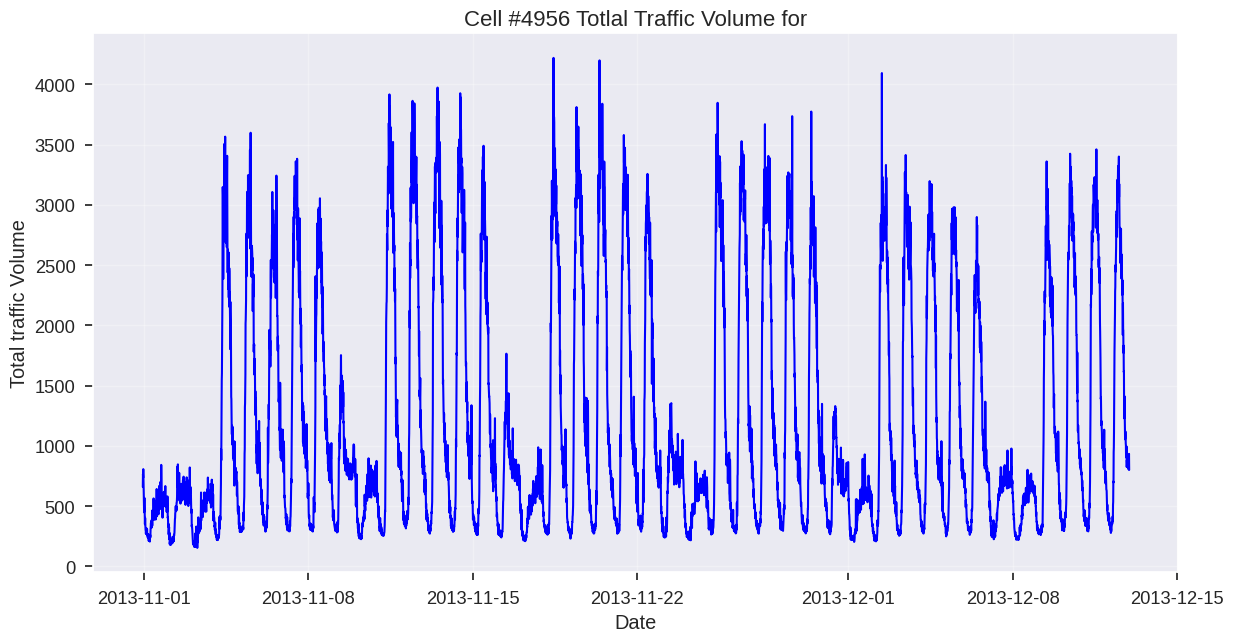

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(series_df, color='blue')
plt.title('Cell #4956 Totlal Traffic Volume for', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total traffic Volume')
plt.grid(True, alpha=0.3)
plt.show()

### Observations

The time series appears seasonal with:

-   Primary seasonality: Daily

-   Secondary pattern: Weekly layered on top of the daily pattern.
    -   Drop Periods: correspond to weekends (consistent low traffic every 7 days).


### Confirm Seasonality Statistically

1. We use STL with period 24 as:
    - roubus to outliers.
    - handle non-stationary seasonality.
2. ACF to confrirm the 24-hrs lag cycle.
3. Kruskal-Wallis to statistically confirm traffic at different times (hours of the day) is significantly different.


#### Daily Seasonality


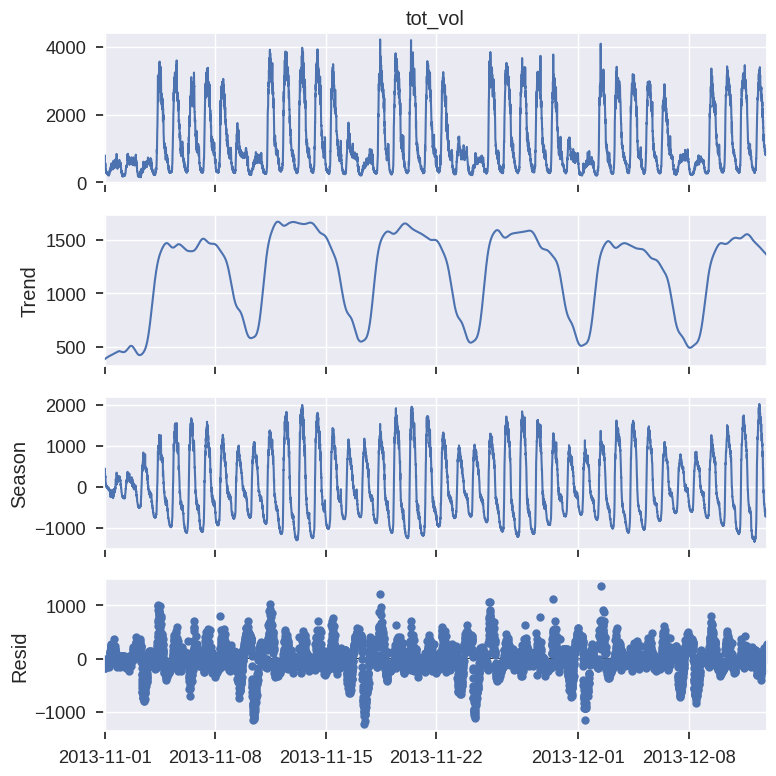

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(series_df[SeriesComp.VALUE.value], period=24*6)      # one day seasonality in 10-min interval data
res = stl.fit()
res.plot()
plt.show()

In [ ]:
# Seasonality Strength

seasonal_var = np.var(res.seasonal)
residual_var = np.var(res.resid)
strength = seasonal_var / (seasonal_var + residual_var)
print(f"Seasonality strength: {strength:.2f}")

Seasonality strength: 0.89


#### Observations:

-   Strong daily patterns.

-   **Trend**: shows weekly-like dips and recoveries:

    -   reflecting weekend effects (lower traffic on weekends).
    -   separating low-frequency trend variation from high-frequency daily cycles.

-   **Seasonality**: captures the core daily shape of the signal: - High peaks during active hours. - Lows during night/inactive hours.
    The amplitude of the seasonality seems mostly stable, with slight variation

-   **Residual**:
    -   Most values stay within a reasonable band, though some spikes suggest localized anomalies (e.g., special events, outages).

**Seasonality Strength Metric** shows a very strong seasonality of 89%.


### ACF

-   Daily datapoints = 144, lags of 200 is enough to capture the daily seasonality.


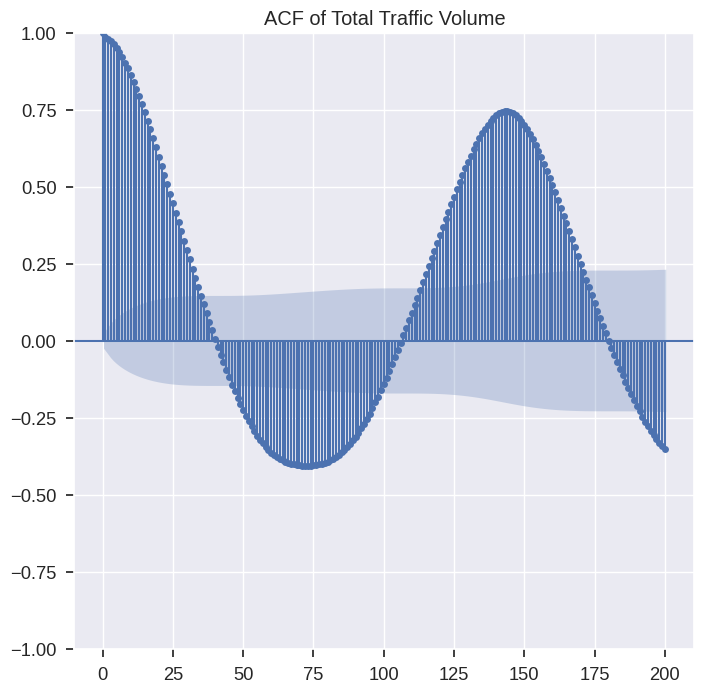

In [ ]:
plot_acf(series_df[SeriesComp.VALUE.value], lags=200)
plt.title("ACF of Total Traffic Volume")
plt.show()

-   First dip at lag 72 (~144/2): inverse correlation with data half a day apart.

-   Second strong positive peak at lag 144: confirms daily seasonality.

-   The repeating cosine-like pattern indicates regular, stable cycles.


### Kruskal-Wallis Test for Seasonality

To check if the distribution of values differs significantly between across hours of the day.


In [ ]:
new_series_df = series_df.copy()

# Create a column for hour of day (0 to 143)
new_series_df['time_of_day'] = (new_series_df.index.hour * 6) + (new_series_df.index.minute // 10)

# Group values by time_of_day
groups = [new_series_df[new_series_df['time_of_day'] == t][SeriesComp.VALUE.value].values for t in range(24*6)]

stat, p = kruskal(*groups)
print(f"Kruskal-Wallis statistic: {stat:.2f}, p-value: {p:.4e}")

Kruskal-Wallis statistic: 4148.50, p-value: 0.0000e+00


-   There are significant differences in total traffic volume across different times of day.

-   p < 0.05: we reject the null hypothesis that all time intervals have the same distribution.

-   Combined with STL and ACF, this strongly confirms daily seasonality from both:

    -   Statistical perspective.

    -   Visual perspective.


#### Weekly Seasonlity


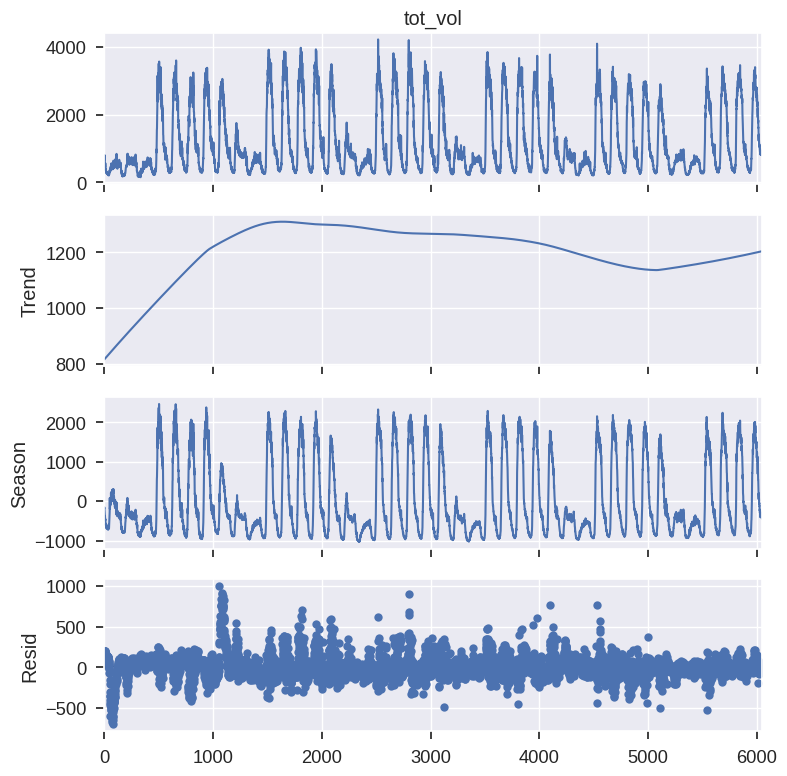

In [ ]:
stl = STL(df[SeriesComp.VALUE.value], period=24*6*7)      # one week seasonality in 10-min interval data
res = stl.fit()
res.plot()
plt.show()

In [ ]:
# Seasonality Strength

seasonal_var = np.var(res.seasonal)
residual_var = np.var(res.resid)
strength = seasonal_var / (seasonal_var + residual_var)
print(f"Seasonality strength: {strength:.2f}")

Seasonality strength: 0.98


#### Observations:

-   Strong repeating cycles, confirming regular daily behavior.

-   **Trend**:

    -   The trend component is much smoother now, since daily variations were absorbed by the seasonal component.
    -   Captures long-term drift.

-   **Seasonality**: captures weekly periodicity:

    -   strong weekly seasonal structure, on top of daily cycles.
    -   daily seasonality has been absorbed into the residuals.

-   **Residual**:
    -   Residuals remain mostly centered around zero.
    -   Spikes still occur.
    -   No visible autocorrelation or pattern: STL isolated seasonality perfectly.

**Seasonality Strength Metric** shows a very strong seasonality of 98%.


#### ACF Weekly

-   Daily datapoints = 1008, lags of 1100 is enough to capture the weekly seasonality.


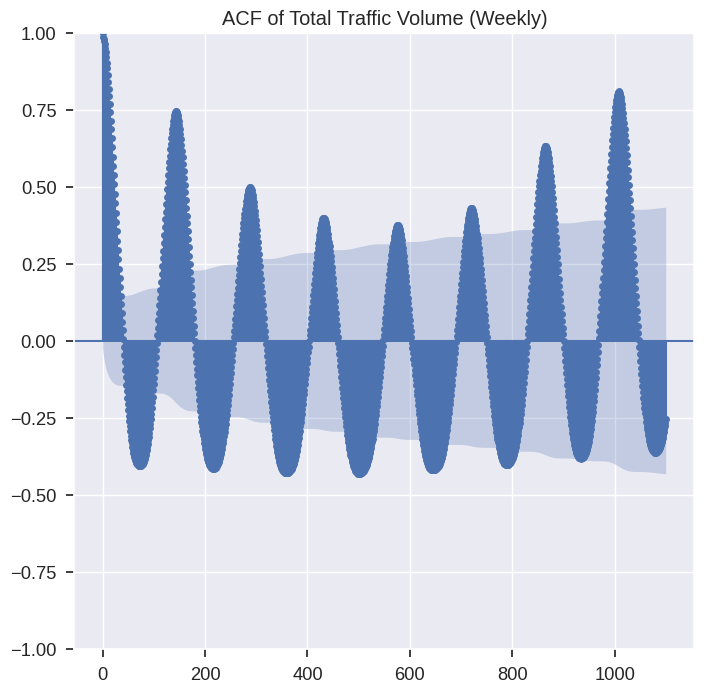

In [ ]:
plot_acf(series_df[SeriesComp.VALUE.value], lags=1100)
plt.title("ACF of Total Traffic Volume (Weekly)")
plt.show()

-   Strong, periodic spikes in autocorrelation: At lags: 0, 144, 288, 432, ..., up to 1008

-   The pattern repeats cleanly, with very high autocorrelation near lag 1008.

In [ ]:
new_series_df['day_of_week'] = new_series_df.index.dayofweek
groups = [new_series_df[new_series_df['day_of_week'] == d][SeriesComp.VALUE.value].values for d in range(7)]

stat, p = kruskal(*groups)
print(f"Kruskal-Wallis Weekly statistic: {stat:.2f}, p-value: {p:.4e}")

Kruskal-Wallis Weekly statistic: 909.11, p-value: 4.0276e-193


Now, confirming both daily and weekly seasonality


### Compined


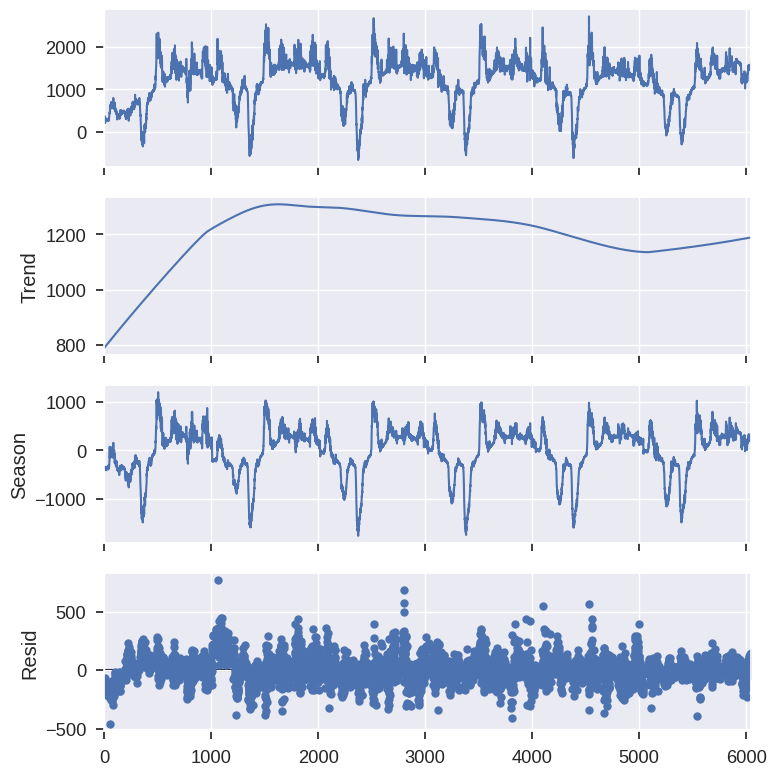

In [ ]:
stl_daily = STL(df[SeriesComp.VALUE.value], period=24*6).fit()
deseasonalized = df[SeriesComp.VALUE.value] - stl_daily.seasonal

stl_weekly = STL(deseasonalized, period=24*6*7).fit()
stl_weekly.plot()
plt.show()

While ACF shows correlation between a time series and its lagged values (including indirect effects), PACF shows the direct correlation with lags after removing the influence of intermediate lags.

-   PACF to determine how many past values directly influence the present → gives AR order p.

-   ACF to assess how much past noise/errors influence the current → helps with MA order q.


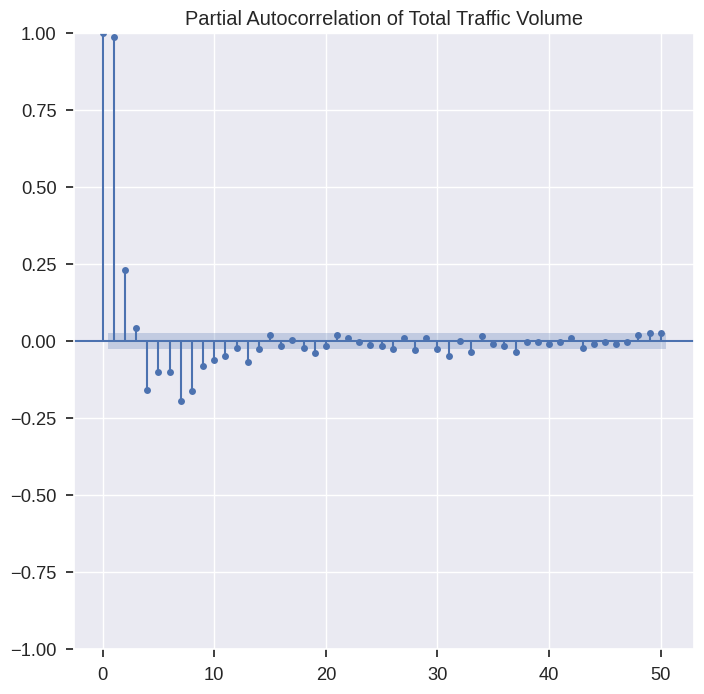

In [ ]:
plot_pacf(series_df[SeriesComp.VALUE.value], lags=50, method='ywm')
plt.title("Partial Autocorrelation of Total Traffic Volume")
plt.show()

-   Lag 1 and 2: Strong and significant spikes → high partial autocorrelation

-   Lag 3: Still slightly above confidence band

-   Beyond lag 4: Rapid decay, values mostly within confidence bounds

**Interpretation**:

-   There's significant short-term dependency up to lag 2-3
-   AR component p = 2 or 3.


## Stationary Test


In [ ]:
# Augmented Dickey-Fuller Test for Stationarity
def perform_adf_test(series, title):
    print(f"ADF Test for {title}:")
    result = adfuller(series.dropna())

    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] < 0.05:
        print("Series is stationary (reject null hypothesis)")
    else:
        print("Series is non-stationary (fail to reject null hypothesis)")

In [ ]:
perform_adf_test(series_df[SeriesComp.VALUE.value], "Non-Stationary Series")
print("-"*30)

ADF Test for Non-Stationary Series:
ADF Statistic: -12.3021
p-value: 0.0000
Critical Values:
	1%: -3.4314
	5%: -2.8620
	10%: -2.5670
Series is stationary (reject null hypothesis)
------------------------------


-   series is likely trend-stationary with deterministic seasonal cycles.

-   To further confirm it, we apply stationarity test after removing daily seasonality.


In [ ]:
stat, p, *_ = adfuller(stl_daily.resid)
print(f"ADF on residuals: stat={stat:.2f}, p={p:.4e}")

ADF on residuals: stat=-13.32, p=6.4745e-25


still holds.


## Time Series Forecasting


In [ ]:
# performing gridsearch
from itertools import product

def arima_grid_search(time_series):
    p = d = q = range(0,3)
    param = list(product(p,d,q))

    best_aic = np.inf
    best_order = None
    best_arima_model = None

    for order in param:
        try:
            arima_model = ARIMA(time_series, order=order).fit()
            if arima_model.aic < best_aic:
                best_arima_model = arima_model
                best_order = order
                best_aic = arima_model.aic
        except:
            continue

    return best_arima_model, best_order, best_aic

### Train-test (4-2 weeks)


In [ ]:
TEST_COUNT = 6*12     # 12 hours

In [ ]:
train = series_df[:-TEST_COUNT]
test = series_df[-TEST_COUNT :]

In [ ]:
best_arima_model, best_order, best_aic = arima_grid_search(train)

In [ ]:
print(f"Best ARIMA order (p,d,q): {best_order} | AIC: {best_aic}")

Best ARIMA order (p,d,q): (2, 0, 2) | AIC: 76353.81262479528


In [ ]:
forecast = best_arima_model.forecast(steps=TEST_COUNT)
forecast = pd.Series(forecast, index=test.index)

In [ ]:
mae = mean_absolute_error(test, forecast)
rmse = root_mean_squared_error(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 147.28
RMSE: 175.18


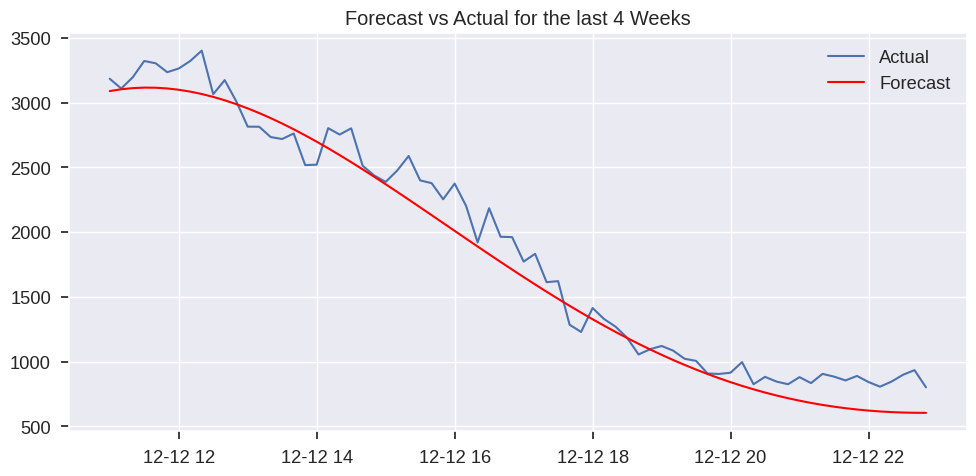

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Forecast vs Actual for the last 12 hours')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def compute_nrmse(y_true, y_pred):
    """
    y_true and y_pred must be numpy arrays of shape (samples, T_out, H, W)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Flatten predictions and ground truth
    d_true = y_true.flatten()
    d_pred = y_pred.flatten()

    N = d_true.shape[0]
    d_mean = np.mean(d_true)

    rmse = np.sqrt(np.sum((d_pred - d_true) ** 2) / N)
    nrmse = rmse / d_mean

    return np.round(nrmse, 4)

In [ ]:
nmrse = compute_nrmse(test, forecast)

print(f"NRMSE: {nmrse}")

NRMSE: 0.0926
